# Visualize two-layer transformer attention pattern

## Without RoPE


In [32]:
# Configuration
import torch
import numpy as np
K=8192
N=8 
D=64
L=32    
alpha=0.0
B=2
p_B=1.0  
p_C=0.0 
eps=0.1  
no_repeats=False 
n_heads=1 
n_layers=2 
rope=False
rope_theta=10000  
rms_norm=True
batch_size=128
optimizer="SGD"
device=0
Nmax = 32
P = 1.0/(np.arange(1,K+1)**alpha)
P /= np.sum(P)
SEED = int(device)
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
if rope:
    input_dim = D
else:
    input_dim = 2*Nmax + 1 + D
prefix = f"./outs_torch/K{K}_N{N}_D{D}_alpha{alpha}_B{B}_pB{p_B}_pC{p_C}_eps{eps}_no_repeats{no_repeats}_rope{rope}_rope_theta{rope_theta}_n_heads{n_heads}_n_layers{n_layers}_rms_norm{rms_norm}_optimizer{optimizer}/seed_{SEED}/"


In [27]:
# Initilize model
from model import Transformer, ModelArgs

model_args = ModelArgs(
    dim=input_dim,
    n_layers=n_layers,
    n_heads=n_heads,
    n_labels=L,
    max_position_embeddings=2*N+1,
    rope_theta=rope_theta,
    mlp_bias=True,
    rms_norm=rms_norm,
    rope=rope,
    norm_eps=1e-5
)
model = Transformer(model_args)
print("Model structure:")
print(model)

Model structure:
Transformer(
  (layers): ModuleList(
    (0-1): 2 x TransformerBlock(
      (attn): Attention(
        (wq): Linear(in_features=129, out_features=129, bias=False)
        (wk): Linear(in_features=129, out_features=129, bias=False)
        (wv): Linear(in_features=129, out_features=129, bias=False)
      )
      (mlp): MLP(
        (fc1): Linear(in_features=129, out_features=129, bias=True)
        (fc2): Linear(in_features=129, out_features=129, bias=True)
        (fc3): Linear(in_features=129, out_features=129, bias=True)
        (act): SiLU()
      )
      (attn_norm): RMSNorm()
      (mlp_norm): RMSNorm()
    )
  )
  (norm): RMSNorm()
  (out): Linear(in_features=129, out_features=32, bias=False)
)


In [33]:
ckpt_path = f"{prefix}/ckpt_140000.pt"
model.load_state_dict(torch.load(ckpt_path, weights_only=True))

<All keys matched successfully>

In [34]:
# Sample a random item-label pair
from dataset import get_mus_label_class, generate_input_seqs
mus_label, mus_class, labels_class = get_mus_label_class(K,L,D)
test_inputs_ic, test_labels_ic, label_sequences =  generate_input_seqs(mus_label,mus_class,labels_class,N,1, Nmax,eps = eps, P = P, B = B, p_B = 1, p_C = 1, seq_labels=True,rope=rope)
print(label_sequences)


tensor([[25., 19.,  7., 25.,  7., 26., 26., 19., 19.]])


In [35]:
# Get attention weights
model.eval()
with torch.no_grad():
    outputs, attn_weights = model(test_inputs_ic, output_attn_weights=True)



torch.Size([17, 17])
torch.Size([17, 17])


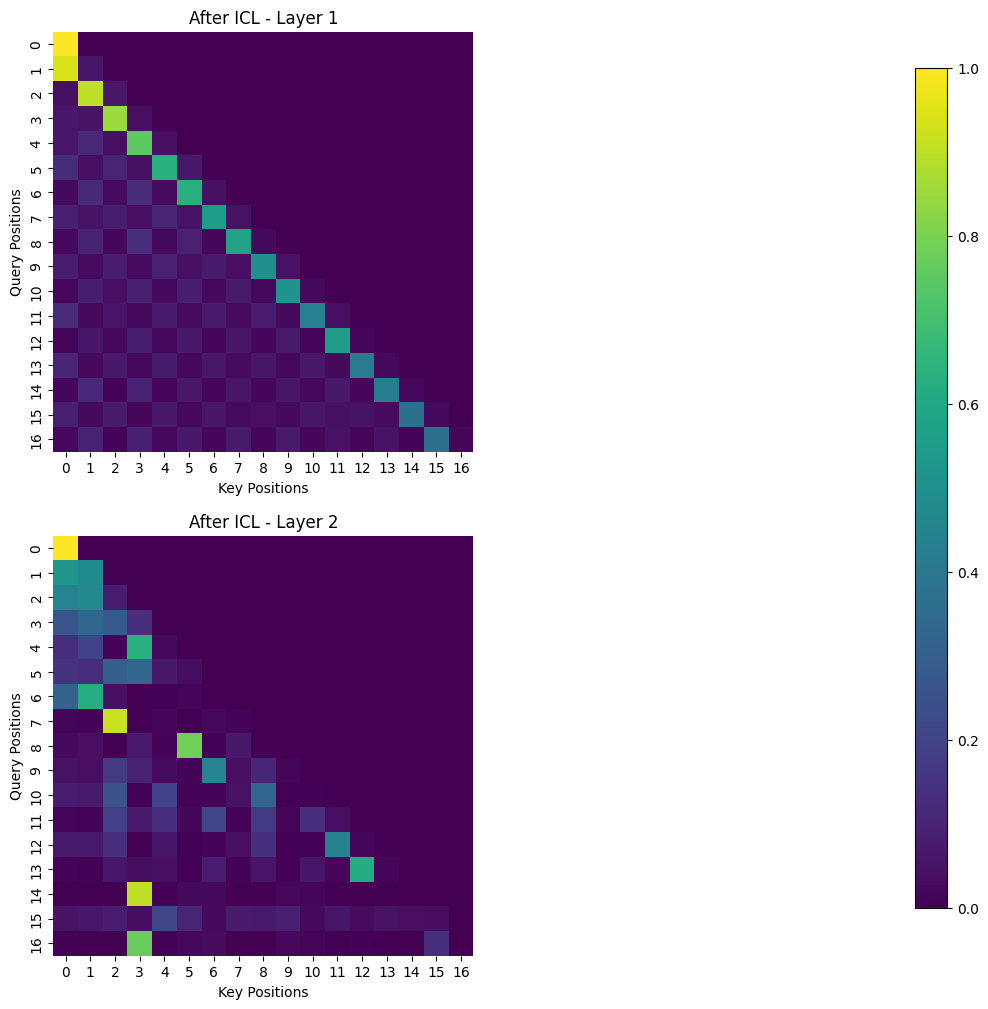

In [36]:
# Plot attention weights
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot attention matrices
def plot_attention_matrices(attn_1, attn_2, axes,  cbar_ax=None):
    """Plots attention matrices for two layers, aligning them in a column."""
    attn_matrix_1 = attn_1
    sns.heatmap(attn_matrix_1, cmap="viridis", annot=False, fmt=".2f", square=True, ax=axes[0], cbar=False)
    axes[0].set_title("After ICL" + " - Layer 1")
    axes[0].set_xlabel("Key Positions")
    axes[0].set_ylabel("Query Positions")
    
    attn_matrix_2 = attn_2
    sns.heatmap(attn_matrix_2, cmap="viridis", annot=False, fmt=".2f", square=True, ax=axes[1], cbar=False)
    axes[1].set_title("After ICL" + " - Layer 2")
    axes[1].set_xlabel("Key Positions")
    axes[1].set_ylabel("Query Positions")

    # Add a colorbar outside the grid, to the right
    if cbar_ax is not None:
        fig.colorbar(axes[0].collections[0], cax=cbar_ax)

# Create a figure with 2 rows and 3 columns (layers as rows, ICL states as columns)
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Create an additional axis for the colorbar on the right of the heatmaps
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Right side of the figure

attn_1, attn_2 = attn_weights
attn_1 =  attn_1.squeeze(0).squeeze(0)
attn_2 = attn_2.squeeze(0).squeeze(0)
print(attn_1.shape)
print(attn_2.shape)
plot_attention_matrices(attn_1, attn_2, axes, cbar_ax)

# With RoPE

In [1]:
import numpy as np
import torch
K=8192
N=8 
D=64
L=32    
alpha=0.0
B=2
p_B=1.0  
p_C=0.75 
eps=0.1  
no_repeats=False 
n_heads=1 
n_layers=2 
rope=True
rope_theta=10000  
rms_norm=True
batch_size=128
optimizer="SGD"
device=0
Nmax = 32
niters = 300000
P = 1.0/(np.arange(1,K+1)**alpha)
P /= np.sum(P)
SEED = device
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
if rope:
    input_dim = D
else:
    input_dim = 2*Nmax + 1 + D
prefix = f"./outs_torch/K{K}_N{N}_D{D}_alpha{alpha}_B{B}_pB{p_B}_pC{p_C}_eps{eps}_no_repeats{no_repeats}_rope{rope}_rope_theta{rope_theta}_n_heads{n_heads}_n_layers{n_layers}_rms_norm{rms_norm}_optimizer{optimizer}_niters{niters}/seed_0/"
print(prefix)


./outs_torch/K8192_N8_D64_alpha0.0_B2_pB1.0_pC0.75_eps0.1_no_repeatsFalse_ropeTrue_rope_theta10000_n_heads1_n_layers2_rms_normTrue_optimizerSGD_niters300000/seed_0/


In [2]:
# Initilize model
from model import Transformer, ModelArgs

model_args = ModelArgs(
    dim=input_dim,
    n_layers=n_layers,
    n_heads=n_heads,
    n_labels=L,
    max_position_embeddings=2*N+1,
    rope_theta=rope_theta,
    mlp_bias=True,
    rms_norm=rms_norm,
    rope=rope,
    norm_eps=1e-5
)
model = Transformer(model_args)
print("Model structure:")
print(model)

Model structure:
Transformer(
  (layers): ModuleList(
    (0-1): 2 x TransformerBlock(
      (attn): Attention(
        (wq): Linear(in_features=64, out_features=64, bias=False)
        (wk): Linear(in_features=64, out_features=64, bias=False)
        (wv): Linear(in_features=64, out_features=64, bias=False)
        (rotary_emb): RotaryEmbedding()
      )
      (mlp): MLP(
        (fc1): Linear(in_features=64, out_features=64, bias=True)
        (fc2): Linear(in_features=64, out_features=64, bias=True)
        (fc3): Linear(in_features=64, out_features=64, bias=True)
        (act): SiLU()
      )
      (attn_norm): RMSNorm()
      (mlp_norm): RMSNorm()
    )
  )
  (norm): RMSNorm()
  (out): Linear(in_features=64, out_features=32, bias=False)
)


In [3]:
ckpt_path = f"{prefix}/ckpt_290000.pt"
model.load_state_dict(torch.load(ckpt_path, weights_only=True))

<All keys matched successfully>

In [4]:
# Sample a random item-label pair
from dataset import get_mus_label_class, generate_input_seqs
mus_label, mus_class, labels_class = get_mus_label_class(K,L,D)
test_inputs_ic, test_labels_ic, label_sequences =  generate_input_seqs(mus_label,mus_class,labels_class,N,1, Nmax,eps = eps, P = P, B = B, p_B = 1, p_C = 1, seq_labels=True,rope=rope)
print(label_sequences)


tensor([[25., 19.,  7., 25.,  7., 26., 26., 19., 19.]])


In [5]:
# Get attention weights
model.eval()
with torch.no_grad():
    outputs, attn_weights = model(test_inputs_ic, output_attn_weights=True)
prediction = np.argmax(outputs, axis=1)
print(prediction)


tensor([19])


torch.Size([17, 17])
torch.Size([17, 17])


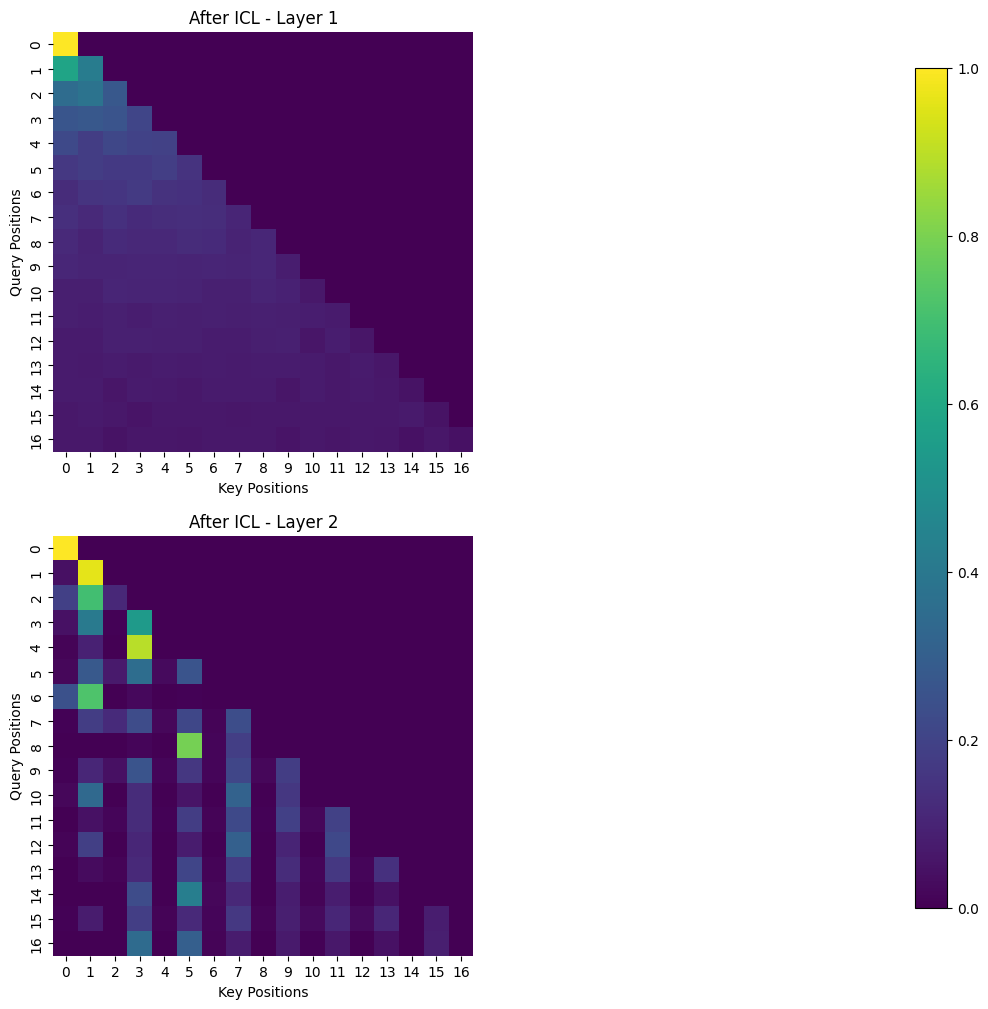

In [6]:
# Plot attention weights
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot attention matrices
def plot_attention_matrices(attn_1, attn_2, axes,  cbar_ax=None):
    """Plots attention matrices for two layers, aligning them in a column."""
    attn_matrix_1 = attn_1
    sns.heatmap(attn_matrix_1, cmap="viridis", annot=False, fmt=".2f", square=True, ax=axes[0], cbar=False)
    axes[0].set_title("After ICL" + " - Layer 1")
    axes[0].set_xlabel("Key Positions")
    axes[0].set_ylabel("Query Positions")
    
    attn_matrix_2 = attn_2
    sns.heatmap(attn_matrix_2, cmap="viridis", annot=False, fmt=".2f", square=True, ax=axes[1], cbar=False)
    axes[1].set_title("After ICL" + " - Layer 2")
    axes[1].set_xlabel("Key Positions")
    axes[1].set_ylabel("Query Positions")

    # Add a colorbar outside the grid, to the right
    if cbar_ax is not None:
        fig.colorbar(axes[0].collections[0], cax=cbar_ax)

# Create a figure with 2 rows and 3 columns (layers as rows, ICL states as columns)
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Create an additional axis for the colorbar on the right of the heatmaps
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Right side of the figure

attn_1, attn_2 = attn_weights
attn_1 =  attn_1.squeeze(0).squeeze(0)
attn_2 = attn_2.squeeze(0).squeeze(0)
print(attn_1.shape)
print(attn_2.shape)
plot_attention_matrices(attn_1, attn_2, axes, cbar_ax)

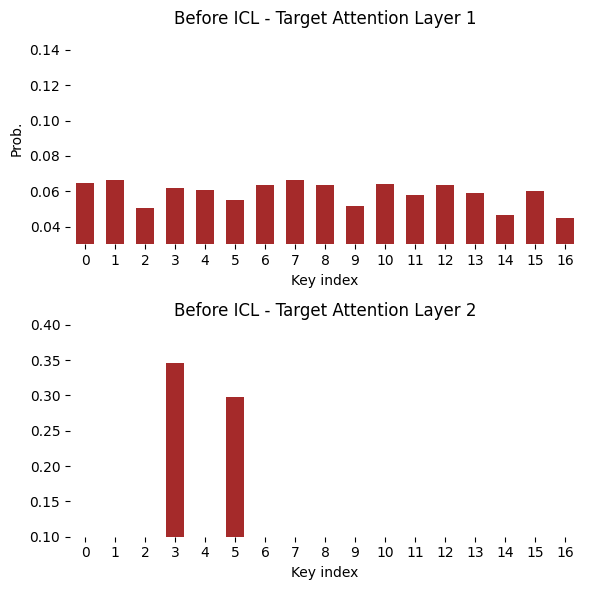

In [7]:

def plot_attention_distributions(attn_1, attn_2, axes, title_prefix):
    data1 = attn_1
    data2 = attn_2

    # Layer 1
    axes[0].bar(range(len(data1)), data1, color='brown', width=0.6)
    axes[0].set_xlabel("Key index")
    axes[0].set_ylabel("Prob.")
    axes[0].set_xticks(range(len(data1)))
    axes[0].set_xticklabels(range(len(data1)))
    axes[0].set_ylim(0.03, 0.15)
    axes[0].set_xlim(-0.5, len(data1) - 0.5)
    axes[0].set_title(f"{title_prefix} - Target Attention Layer 1")
    for spine in axes[0].spines.values():
        spine.set_visible(False)

    # Layer 2
    axes[1].bar(range(len(data2)), data2, color='brown', width=0.6)
    axes[1].set_xlabel("Key index")
    axes[1].set_xticks(range(len(data2)))
    axes[1].set_xticklabels(range(len(data2)))
    axes[1].set_ylim(0.1, 0.4)
    axes[1].set_xlim(-0.5, len(data2) - 0.5)
    axes[1].set_title(f"{title_prefix} - Target Attention Layer 2")
    for spine in axes[1].spines.values():
        spine.set_visible(False)

# Create a single column with two subplots
fig, axes = plt.subplots(2, 1, figsize=(6, 6))  # 2 rows, 1 column
plot_attention_distributions(attn_1[-1], attn_2[-1], axes, "Before ICL")
plt.tight_layout()
plt.show()